# Toy data: more features

In [1]:
import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

from artool import ar_io, toy

# remove col/row limits
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


## Inputs

In [2]:
date_start = datetime.datetime(2022, 3, 1)
date_end = datetime.datetime(2022, 9, 1)
symbols = toy.toy_data.get_symbol_list(date_start, date_end)
print(len(symbols))


178


## Play

In [3]:
features = ["funding_timestamp", "funding_rate", "index_price", "mark_price"]
symbol_test = "BTCUSDT"
df_test = toy.toy_data.get_symbol_data_coarse(
    symbol_test, date_start=date_start, date_end=date_end, features=features
)
df_test.head()


,funding_timestamp,funding_rate,index_price,mark_price,symbol
0,1.646122e+15,0.000100,43172.100507,43160.688900,BTCUSDT
1,1.646150e+15,0.000100,43491.567169,43471.600000,BTCUSDT
2,1.646179e+15,0.000044,43647.108822,43627.072255,BTCUSDT
3,1.646208e+15,-0.000005,44421.950768,44397.000000,BTCUSDT
4,1.646237e+15,0.000100,43967.035906,43963.000000,BTCUSDT


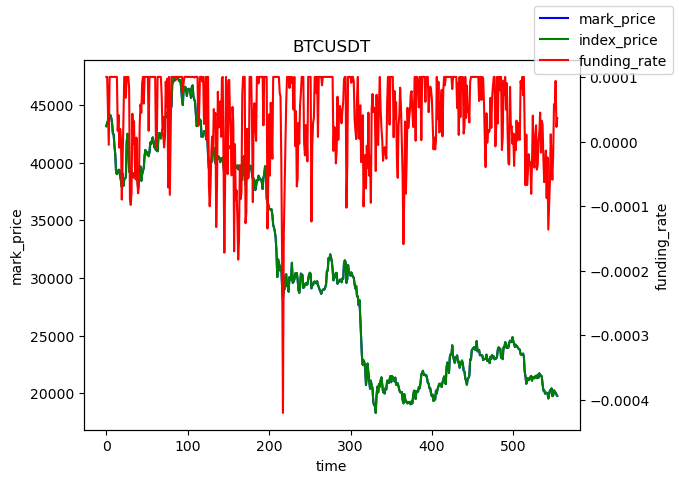

In [4]:
# plot funding_rate mark_price in df_test
fig, ax = plt.subplots()
ax.plot(df_test["mark_price"], color="blue", label="mark_price")
ax.plot(df_test["index_price"], color="green", label="index_price")
ax2 = ax.twinx()
ax2.plot(df_test["funding_rate"], color="red", label="funding_rate")
ax.set_title(f"{symbol_test}")
ax.set_xlabel("time")
ax.set_ylabel("mark_price")
ax2.set_ylabel("funding_rate")
fig.legend()
plt.show()


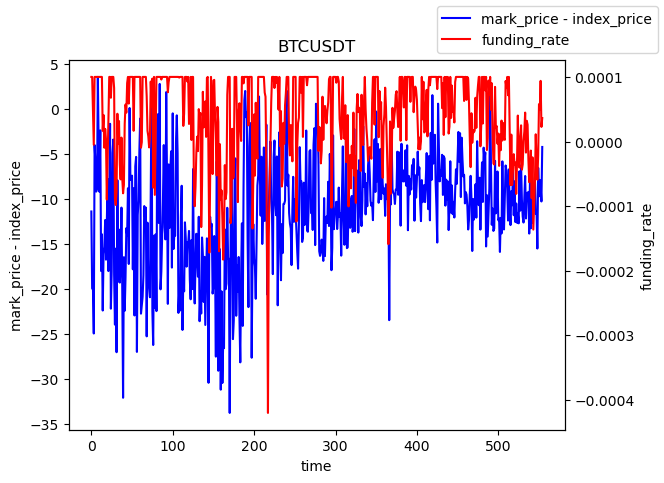

In [5]:
price_diff = df_test["mark_price"] - df_test["index_price"]
fig, ax = plt.subplots()
ax.plot(price_diff, color="blue", label="mark_price - index_price")
ax2 = ax.twinx()
ax2.plot(df_test["funding_rate"], color="red", label="funding_rate")
ax.set_title(f"{symbol_test}")
ax.set_xlabel("time")
ax.set_ylabel("mark_price - index_price")
ax2.set_ylabel("funding_rate")
fig.legend()
plt.show()


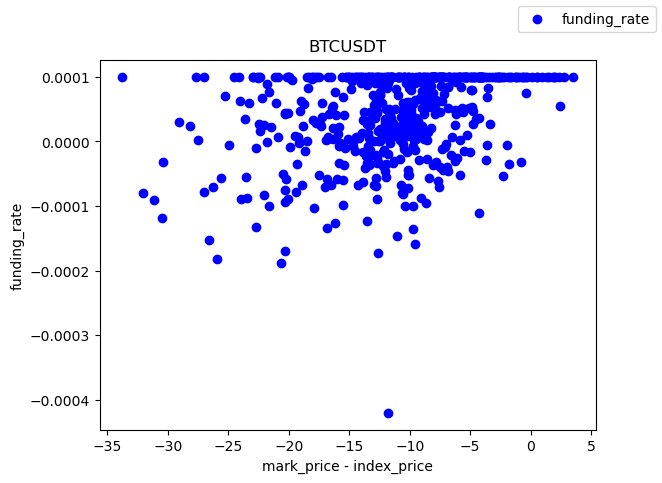

corr: 0.32136162675150887


In [6]:
# plot funding_rate vs price_diff
fig, ax = plt.subplots()
ax.scatter(price_diff, df_test["funding_rate"], color="blue", label="funding_rate")
ax.set_title(f"{symbol_test}")
ax.set_xlabel("mark_price - index_price")
ax.set_ylabel("funding_rate")
fig.legend()
plt.show()

corr = df_test["funding_rate"].corr(price_diff)
print(f"corr: {corr}")


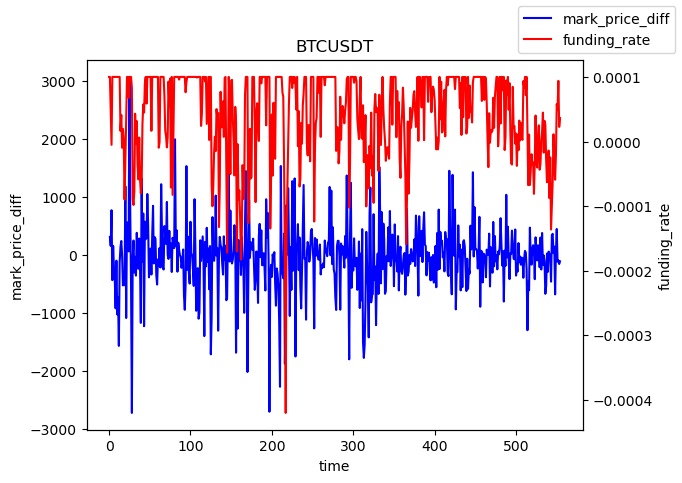

In [7]:
mark_price_diff = df_test["mark_price"].diff()
funding_rate = df_test["funding_rate"]

fig, ax = plt.subplots()
ax.plot(mark_price_diff, color="blue", label="mark_price_diff")
ax2 = ax.twinx()
ax2.plot(funding_rate, color="red", label="funding_rate")
ax.set_title(f"{symbol_test}")
ax.set_xlabel("time")
ax.set_ylabel("mark_price_diff")
ax2.set_ylabel("funding_rate")
fig.legend()
plt.show()


In [8]:
# cound nan for last_price_diff
print(mark_price_diff.isna().sum())


1


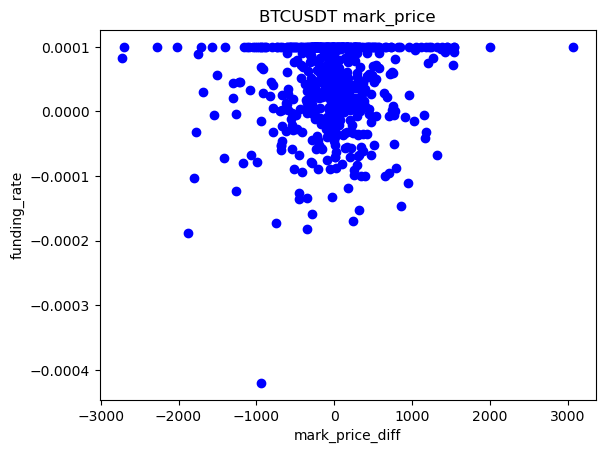

0.06577554542971328


In [9]:
# plot correlation between mark_price_diff and funding_rate
fig, ax = plt.subplots()
ax.scatter(mark_price_diff, funding_rate, color="blue", label="mark_price_diff")
ax.set_title(f"{symbol_test} mark_price")
ax.set_xlabel("mark_price_diff")
ax.set_ylabel("funding_rate")
plt.show()

# drop nan for mark_price_diff and funding_rate together
df_tmp = pd.DataFrame(
    {"mark_price_diff": mark_price_diff, "funding_rate": funding_rate}
)
df_tmp = df_tmp.dropna()

# calculate correlation between mark_price_diff and funding_rate
corr = df_tmp["mark_price_diff"].corr(df_tmp["funding_rate"])
print(corr)


## Feature engineer v2

In [10]:
features = ["funding_timestamp", "funding_rate", "index_price", "mark_price"]
symbol_test = "BTCUSDT"
df_test = toy.toy_data.get_symbol_data_coarse(
    symbol_test, date_start=date_start, date_end=date_end, features=features
)
df_test.head()


,funding_timestamp,funding_rate,index_price,mark_price,symbol
0,1.646122e+15,0.000100,43172.100507,43160.688900,BTCUSDT
1,1.646150e+15,0.000100,43491.567169,43471.600000,BTCUSDT
2,1.646179e+15,0.000044,43647.108822,43627.072255,BTCUSDT
3,1.646208e+15,-0.000005,44421.950768,44397.000000,BTCUSDT
4,1.646237e+15,0.000100,43967.035906,43963.000000,BTCUSDT


In [11]:
from scipy.signal import lfilter


def process_df(df_in, features_save, features_fe):

    df = df_in[features_save].copy()
    new_cols = {}

    for feature in features_fe:
        # Add exponential decay sum
        for lookback in [0.5, 1, 2, 3, 5, 10, 20, 50]:
            decay_rate = np.exp(-1 / lookback)
            new_cols[f"{feature}_expcumsum_{lookback}"] = lfilter(
                [decay_rate], [1, -decay_rate], df[feature]
            )
        # Add rolling features
        for lookback in [3, 5, 10, 20, 50]:
            new_cols[f"{feature}_rol_mean_{lookback}"] = (
                df[feature].rolling(lookback, min_periods=1).mean()
            )
            new_cols[f"{feature}_rol_std_{lookback}"] = (
                df[feature].rolling(lookback, min_periods=1).std()
            )
            new_cols[f"{feature}_rol_max_{lookback}"] = (
                df[feature].rolling(lookback, min_periods=1).max()
            )
            new_cols[f"{feature}_rol_min_{lookback}"] = (
                df[feature].rolling(lookback, min_periods=1).min()
            )
            new_cols[f"{feature}_rol_skew_{lookback}"] = (
                df[feature].rolling(lookback, min_periods=1).skew()
            )
            if lookback > 3:
                new_cols[f"{feature}_rol_kurt_{lookback}"] = (
                    df[feature].rolling(lookback, min_periods=1).kurt()
                )
        # Add difference bewteen cumsum with 5 interval
        cur_cumsum = df["funding_rate"].cumsum()
        for lookforward in [1, 2, 3, 5, 10]:
            new_cols[
                f"funding_rate_future_{lookforward}"
            ] = cur_cumsum - cur_cumsum.shift(lookforward)

    df_append = pd.DataFrame(new_cols)
    return pd.concat([df, df_append], axis=1)


In [12]:
features_save = [
    "symbol",
    "funding_timestamp",
    "funding_rate",
    "index_price",
    "mark_price",
]
features_fe = ["funding_rate", "index_price", "mark_price"]
df_fe = process_df(df_test, features_save, features_fe)
df_fe.sample(20)


,symbol,funding_timestamp,funding_rate,index_price,mark_price,funding_rate_expcumsum_0.5,funding_rate_expcumsum_1,funding_rate_expcumsum_2,funding_rate_expcumsum_3,funding_rate_expcumsum_5,funding_rate_expcumsum_10,funding_rate_expcumsum_20,funding_rate_expcumsum_50,funding_rate_rol_mean_3,funding_rate_rol_std_3,funding_rate_rol_max_3,funding_rate_rol_min_3,funding_rate_rol_skew_3,funding_rate_rol_mean_5,funding_rate_rol_std_5,funding_rate_rol_max_5,funding_rate_rol_min_5,funding_rate_rol_skew_5,funding_rate_rol_kurt_5,funding_rate_rol_mean_10,funding_rate_rol_std_10,funding_rate_rol_max_10,funding_rate_rol_min_10,funding_rate_rol_skew_10,funding_rate_rol_kurt_10,funding_rate_rol_mean_20,funding_rate_rol_std_20,funding_rate_rol_max_20,funding_rate_rol_min_20,funding_rate_rol_skew_20,funding_rate_rol_kurt_20,funding_rate_rol_mean_50,funding_rate_rol_std_50,funding_rate_rol_max_50,funding_rate_rol_min_50,funding_rate_rol_skew_50,funding_rate_rol_kurt_50,funding_rate_future_1,funding_rate_future_2,funding_rate_future_3,funding_rate_future_5,funding_rate_future_10,index_price_expcumsum_0.5,index_price_expcumsum_1,index_price_expcumsum_2,index_price_expcumsum_3,index_price_expcumsum_5,index_price_expcumsum_10,index_price_expcumsum_20,index_price_expcumsum_50,index_price_rol_mean_3,index_price_rol_std_3,index_price_rol_max_3,index_price_rol_min_3,index_price_rol_skew_3,index_price_rol_mean_5,index_price_rol_std_5,index_price_rol_max_5,index_price_rol_min_5,index_price_rol_skew_5,index_price_rol_kurt_5,index_price_rol_mean_10,index_price_rol_std_10,index_price_rol_max_10,index_price_rol_min_10,index_price_rol_skew_10,index_price_rol_kurt_10,index_price_rol_mean_20,index_price_rol_std_20,index_price_rol_max_20,index_price_rol_min_20,index_price_rol_skew_20,index_price_rol_kurt_20,index_price_rol_mean_50,index_price_rol_std_50,index_price_rol_max_50,index_price_rol_min_50,index_price_rol_skew_50,index_price_rol_kurt_50,mark_price_expcumsum_0.5,mark_price_expcumsum_1,mark_price_expcumsum_2,mark_price_expcumsum_3,mark_price_expcumsum_5,mark_price_expcumsum_10,mark_price_expcumsum_20,mark_price_expcumsum_50,mark_price_rol_mean_3,mark_price_rol_std_3,mark_price_rol_max_3,mark_price_rol_min_3,mark_price_rol_skew_3,mark_price_rol_mean_5,mark_price_rol_std_5,mark_price_rol_max_5,mark_price_rol_min_5,mark_price_rol_skew_5,mark_price_rol_kurt_5,mark_price_rol_mean_10,mark_price_rol_std_10,mark_price_rol_max_10,mark_price_rol_min_10,mark_price_rol_skew_10,mark_price_rol_kurt_10,mark_price_rol_mean_20,mark_price_rol_std_20,mark_price_rol_max_20,mark_price_rol_min_20,mark_price_rol_skew_20,mark_price_rol_kurt_20,mark_price_rol_mean_50,mark_price_rol_std_50,mark_price_rol_max_50,mark_price_rol_min_50,mark_price_rol_skew_50,mark_price_rol_kurt_50
301,BTCUSDT,1.654790e+15,0.000091,30488.133456,30477.800000,1.444086e-05,0.000054,0.000135,0.000203,0.000318,0.000586,0.001150,0.002562,0.000097,5.161511e-06,0.000100,0.000091,-1.732051,0.000098,3.998090e-06,0.000100,0.000091,-2.236068,5.000000,6.482300e-05,7.260374e-05,0.000100,-0.000102,-1.965905,2.723750,0.000048,0.000058,0.000100,-0.000102,-1.138420,0.769906,0.000062,0.000055,0.0001,-0.000124,-1.607706,2.326069,0.000091,0.000191,0.000291,0.000491,0.000648,4766.740370,17707.980839,46921.586041,76973.560120,137504.480419,288865.487039,591261.848004,1.555826e+06,30388.259781,159.656540,30488.133456,30204.124778,-1.713437,30570.089997,336.812934,31121.066056,30204.124778,1.273356,2.706745,30652.968473,659.644334,31537.283029,29585.506664,-0.160032,-1.143547,30279.528744,633.241809,31537.283029,29503.824184,0.749513,-0.579945,30041.123212,882.373191,32060.946172,28625.628565,0.650038,-0.456566,4765.097267,17701.717221,46904.712574,76945.711608,137454.208167,288759.524640,591048.745535,1.555269e+06,30377.100000,160.004969,30477.800000,30192.600000,-1.710338,30560.125568,340.261992,31118.100000,30192.600000,1.296043,2.753579,30642.020999,663.184685,31532.258018,29567.580550,-0.162844,-1.138591,30267.324849,635

In [13]:
df_fe.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Columns: 121 entries, symbol to mark_price_rol_kurt_50
dtypes: float64(120), object(1)
memory usage: 524.8+ KB


In [14]:
df_fe.describe()


,funding_timestamp,funding_rate,index_price,mark_price,funding_rate_expcumsum_0.5,funding_rate_expcumsum_1,funding_rate_expcumsum_2,funding_rate_expcumsum_3,funding_rate_expcumsum_5,funding_rate_expcumsum_10,funding_rate_expcumsum_20,funding_rate_expcumsum_50,funding_rate_rol_mean_3,funding_rate_rol_std_3,funding_rate_rol_max_3,funding_rate_rol_min_3,funding_rate_rol_skew_3,funding_rate_rol_mean_5,funding_rate_rol_std_5,funding_rate_rol_max_5,funding_rate_rol_min_5,funding_rate_rol_skew_5,funding_rate_rol_kurt_5,funding_rate_rol_mean_10,funding_rate_rol_std_10,funding_rate_rol_max_10,funding_rate_rol_min_10,funding_rate_rol_skew_10,funding_rate_rol_kurt_10,funding_rate_rol_mean_20,funding_rate_rol_std_20,funding_rate_rol_max_20,funding_rate_rol_min_20,funding_rate_rol_skew_20,funding_rate_rol_kurt_20,funding_rate_rol_mean_50,funding_rate_rol_std_50,funding_rate_rol_max_50,funding_rate_rol_min_50,funding_rate_rol_skew_50,funding_rate_rol_kurt_50,funding_rate_future_1,funding_rate_future_2,funding_rate_future_3,funding_rate_future_5,funding_rate_future_10,index_price_expcumsum_0.5,index_price_expcumsum_1,index_price_expcumsum_2,index_price_expcumsum_3,index_price_expcumsum_5,index_price_expcumsum_10,index_price_expcumsum_20,index_price_expcumsum_50,index_price_rol_mean_3,index_price_rol_std_3,index_price_rol_max_3,index_price_rol_min_3,index_price_rol_skew_3,index_price_rol_mean_5,index_price_rol_std_5,index_price_rol_max_5,index_price_rol_min_5,index_price_rol_skew_5,index_price_rol_kurt_5,index_price_rol_mean_10,index_price_rol_std_10,index_price_rol_max_10,index_price_rol_min_10,index_price_rol_skew_10,index_price_rol_kurt_10,index_price_rol_mean_20,index_price_rol_std_20,index_price_rol_max_20,index_price_rol_min_20,index_price_rol_skew_20,index_price_rol_kurt_20,index_price_rol_mean_50,index_price_rol_std_50,index_price_rol_max_50,index_price_rol_min_50,index_price_rol_skew_50,index_price_rol_kurt_50,mark_price_expcumsum_0.5,mark_price_expcumsum_1,mark_price_expcumsum_2,mark_price_expcumsum_3,mark_price_expcumsum_5,mark_price_expcumsum_10,mark_price_expcumsum_20,mark_price_expcumsum_50,mark_price_rol_mean_3,mark_price_rol_std_3,mark_price_rol_max_3,mark_price_rol_min_3,mark_price_rol_skew_3,mark_price_rol_mean_5,mark_price_rol_std_5,mark_price_rol_max_5,mark_price_rol_min_5,mark_price_rol_skew_5,mark_price_rol_kurt_5,mark_price_rol_mean_10,mark_price_rol_std_10,mark_price_rol_max_10,mark_price_rol_min_10,mark_price_rol_skew_10,mark_price_rol_kurt_10,mark_price_rol_mean_20,mark_price_rol_std_20,mark_price_rol_max_20,mark_price_rol_min_20,mark_price_rol_skew_20,mark_price_rol_kurt_20,mark_price_rol_mean_50,mark_price_rol_std_50,mark_price_rol_max_50,mark_price_rol_min_50,mark_price_rol_skew_50,mark_price_rol_kurt_50
count,5.550000e+02,555.000000,555.000000,555.000000,5.550000e+02,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,554.000000,555.000000,555.000000,457.000000,555.000000,554.000000,555.000000,555.000000,503.000000,502.000000,555.000000,554.000000,555.000000,555.000000,544.000000,543.000000,555.000000,554.000000,555.000000,555.000000,553.000000,552.000000,555.000000,554.000000,5.550000e+02,555.000000,553.000000,552.000000,554.000000,553.000000,552.000000,550.000000,545.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,5.550000e+02,555.000000,554.000000,555.000000,555.000000,553.000000,555.000000,554.000000,555.000000,555.000000,553.000000,552.000000,555.000000,554.000000,555.000000,555.000000,553.000000,552.000000,555.000000,554.000000,555.000000,555.000000,553.000000,552.000000,555.000000,554.000000,555.000000,555.000000,553.000000,552.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,5.550000e+02,555.000000,554.000000,555.000000,555.000000,553.000000,555.000000,554.000000,555.000000,555.000000,553.000000,552.000000,555.000000,554.000000,555.000000,555.000000,553.000000,552.000000,555.000000,554.000000,555.000